# Non-Negativ Matrix Factorization Model on 1-gram Tokens

TODO
1. Run LDA and SVD on bigrams
2. overall topic gyakoriságra valamilyen vizualizáció (összesen mennyi a hátralékos stb)

2.1 ugyanazt azt a logikát mindegyik get függvényre: két return obj: statisztika + analitika

3. egy main topic esetében leszűrni az első 50 tokenre és azon belül új modell, vagy key-word-extraction
4. évforduló és háralék együttállást érdemes megnézni - lehet, hogy az évfordulót követő felszólítás generálja a legtöbb hívást

In [1]:
import warnings
warnings.simplefilter('ignore')
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
from src.models.build_topic_model import show_topics, drop_topics, sparse_argsort, get_main_topic, get_topic_frequency, get_topic_patterns

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import pyLDAvis
import pyLDAvis.sklearn

### Load dataset

In [2]:
path_to_data = Path('../data')
df = pd.read_csv(path_to_data / 'processed' /'tokenized1gram_data.csv', converters={'tokenized': eval, 'tokenized_mults': eval, 'tokenized_mults_extr': eval})

### Fit model for cleaned token set (excl. extra stops)

In [3]:
tfidf = TfidfVectorizer(analyzer='word', tokenizer=lambda doc: doc, preprocessor = lambda doc: doc, token_pattern=None)
dtm_tfidf = tfidf.fit_transform(df['tokenized_mults_extr'])
vocab = np.array(tfidf.get_feature_names())

nmf_tfidf = NMF(init='random', n_components=8, max_iter=100, random_state = 0)
nmf_tfidf.fit(dtm_tfidf)

pyLDAvis.enable_notebook()
vis_nmf = pyLDAvis.sklearn.prepare(nmf_tfidf, dtm_tfidf, tfidf)
vis_nmf

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.032268  0.099566       1        1  15.247224
2      0.045740  0.069953       2        1  14.208631
7      0.094510 -0.077073       3        1  13.675186
0      0.043586  0.013260       4        1  12.667799
6     -0.096170 -0.085960       5        1  11.966842
5      0.135010  0.167933       6        1  11.602788
4     -0.282608  0.018452       7        1  11.350490
1      0.092200 -0.206132       8        1   9.281041, topic_info=            Term       Freq      Total Category  logprob  loglift
654        csekk  47.000000  47.000000  Default  30.0000  30.0000
1877  hozzájárul  26.000000  26.000000  Default  29.0000  29.0000
2924       levél  37.000000  37.000000  Default  28.0000  28.0000
339         bank  21.000000  21.000000  Default  27.0000  27.0000
2150      jelszó  20.000000  20.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
5298      összeg   4.403226  32.517256   Topic8  -5.1742   0.3778
317    azonosító   3.207383  18.799308   Topic8  -5.4911   0.6088
4708        utal   3.456631  28.818806   Topic8  -5.4162   0.2565
47            ad   3.462711  32.735396   Topic8  -5.4145   0.1308
526    biztosító   2.810000  11.337487   Topic8  -5.6233   0.9823

[619 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
2         5  1.404566            157es
12        8  1.952471  2400dunaújváros
47        1  0.183288               ad
47        2  0.091644               ad
47        3  0.061096               ad
...     ...       ...              ...
5357      6  0.122089           ügyfél
5361      7  0.963195     ügyfélprofil
5362      2  0.323198  ügyfélszolgálat
5362      5  0.484797  ügyfélszolgálat
5369      7  1.030202           ügynök

[967 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 8, 1, 7, 6, 5, 2])

#### Show topic key words

In [4]:
W1 = nmf_tfidf.fit_transform(dtm_tfidf)
H1 = nmf_tfidf.components_

show_topics(H1, num_top_words = 12, vocab = vocab)

['tud szerződés név információ meghatalmazás ért telefon biztosítás ad szerződő segít szám',
 'bank csoportos megbízás levon von beszedési levonás terhelés tud beszedés számla díj',
 'díj évforduló éves biztosítás szerződés fizet következő negyedéves összeg első kötelező nap',
 'levél kap küld biztosítás email hátralék néz cím értesítés ért türelem nap',
 'hozzájárul ajánlat adat elérhetőség akció megkeres szerződés álló ügynök kezelt általa személyes',
 'csekk befizet fizet küld kap negyedév tud negyedéves következő darab első csekken',
 'jelszó tud cím email felület online felhasználónév regisztráció mail küld belép kukac',
 'utal összeg közlemény lát számlaszám pénz utalás ír ügyfél számla kolléga tud']

* 0 - adatvédelmi okokból csak a szerződőnek info 
* 1 - csoportos beszedés nem működött  
* 2 - évfordulóval kapcsolatos díjváltozást nem érti
* 3 - levél vagy email a hátralékról (inter, díjfelszólító)
* 4 - marketing hozzájárulás
* 5 - csekkes befizetés probléma
* 6 - online irányba terelés
* 7 - egyedi utalásos probléma

#### Show main topic distribution

In [5]:
# Drop administrative topics 
W1_clean , H1_clean = drop_topics(W1, H1, drop_list = [0,4,6])

In [7]:
show_topics(H1_clean, num_top_words = 12, vocab = vocab)

['bank csoportos megbízás levon von beszedési levonás terhelés tud beszedés számla díj',
 'díj évforduló éves biztosítás szerződés fizet következő negyedéves összeg első kötelező nap',
 'levél kap küld biztosítás email hátralék néz cím értesítés ért türelem nap',
 'csekk befizet fizet küld kap negyedév tud negyedéves következő darab első csekken',
 'utal összeg közlemény lát számlaszám pénz utalás ír ügyfél számla kolléga tud']

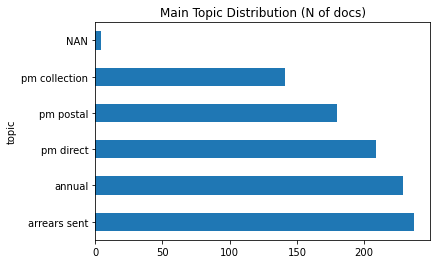

In [6]:
_, main_topic = get_main_topic(W1_clean, ['pm collection', 'annual', 'arrears sent', 'pm postal', 'pm direct', 'NAN'],\
                                    threshold = 0)
main_topic['count'].plot.barh(title = 'Main Topic Distribution (N of docs)');

#### Show topic frequency

In [7]:
topic_freq = get_topic_frequency(W1_clean, ['pm collection', 'annual', 'arrears sent', 'pm postal', 'pm direct'],\
                                    threshold = 0.01)
topic_freq

,count,pct
arrears sent,596,0.250631
annual,578,0.243061
pm direct,507,0.213204
pm postal,418,0.175778
pm collection,279,0.117325


#### Show multi-topic distribution

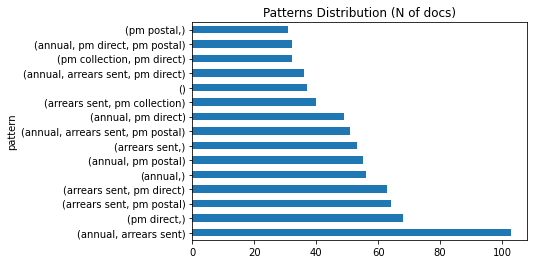

In [16]:
_, topic_patterns = get_topic_patterns(W1_clean, ['pm collection', 'annual', 'arrears sent', 'pm postal', 'pm direct'],\
                                    threshold = 0.015)

topic_patterns = topic_patterns.iloc[0:15, 0]
topic_patterns.plot.barh(title = 'Patterns Distribution (N of docs)');

In [14]:
df_pattern = df.join(pattern_by_doc)
df_pattern.loc[:, ['file_name', 'text', 'pattern']].to_csv(path_to_data / 'processed' / '1gram_pattern_inspect.csv')

### Fit model for main topic

In [87]:
# Subset for main topic
MAIN_TOPIC_ID = 4
NUM_OF_TOPICS = 3

main_topic = pd.DataFrame(W1_clean.argmax(axis = 1), columns = ['main_topic'])
df_subset = df.join(main_topic)
df_subset = df_subset.loc[df_subset['main_topic'] == MAIN_TOPIC_ID, :]

# Fit NMF
dtm_tfidf_subset = tfidf.fit_transform(df_subset['tokenized_mults_extr'])
vocab_subset = np.array(tfidf.get_feature_names())

nmf_tfidf_subset = NMF(init='random', n_components=NUM_OF_TOPICS, max_iter=100, random_state = 0)
nmf_tfidf_subset.fit(dtm_tfidf_subset)

pyLDAvis.enable_notebook()
vis_nmf_subset = pyLDAvis.sklearn.prepare(nmf_tfidf_subset, dtm_tfidf_subset, tfidf)
vis_nmf_subset

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.071068  0.144939       1        1  45.503750
1     -0.153874 -0.113257       2        1  42.815916
0      0.224942 -0.031682       3        1  11.680334, topic_info=             Term      Freq      Total Category  logprob  loglift
1178   hozzájárul  4.000000   4.000000  Default  30.0000  30.0000
20           adat  4.000000   4.000000  Default  29.0000  29.0000
3411       ügyfél  7.000000   7.000000  Default  28.0000  28.0000
53        ajánlat  3.000000   3.000000  Default  27.0000  27.0000
666   elérhetőség  3.000000   3.000000  Default  26.0000  26.0000
...           ...       ...        ...      ...      ...      ...
2225          nap  1.182544   9.476260   Topic3  -5.1716   0.0661
1890          lát  1.030466  10.329204   Topic3  -5.3093  -0.1577
2888          tud  1.103160  22.394770   Topic3  -5.2411  -0.8634
263         belép  0.869424   2.426121   Topic3  -5.4792   1.1210
3003         utal  0.938469  11.237610   Topic3  -5.4028  -0.3355

[306 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
18        1  0.586649                ad
18        2  0.293324                ad
18        3  0.146662                ad
20        1  0.432281              adat
20        3  0.648421              adat
...     ...       ...               ...
3371      2  0.484062            összeg
3411      2  0.978466            ügyfél
3413      3  1.140993      ügyfélprofil
3415      1  1.981678  ügyfélszolgálati
3419      3  0.671601            ügynök

[227 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])